In [1]:
#Load 'financial_phrasebank' corpus 
from datasets import load_dataset
datasets = load_dataset('financial_phrasebank', 'sentences_75agree')
print(datasets["train"][0])

Reusing dataset financial_phrasebank (/home/jingyang/.cache/huggingface/datasets/financial_phrasebank/sentences_75agree/1.0.0/a6d468761d4e0c8ae215c77367e1092bead39deb08fbf4bffd7c0a6991febbf0)


  0%|          | 0/1 [00:00<?, ?it/s]

{'sentence': 'According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .', 'label': 1}


In [2]:
#Load corpus into dataframe
import pandas as pd
df = pd.DataFrame.from_dict(datasets["train"])
df.head(5)

,sentence,label
0,"According to Gran , the company has no plans t...",1
1,With the new production plant the company woul...,2
2,"For the last quarter of 2010 , Componenta 's n...",2
3,"In the third quarter of 2010 , net sales incre...",2
4,Operating profit rose to EUR 13.1 mn from EUR ...,2


In [3]:
#Clean sentences. All punctuation, special characters are removed. All uppercase letters are converted to lowercase.
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
import re

table = str.maketrans('', '', string.punctuation)

def clean(sent):
    words = re.split(r'\W+', sent)
    rem_punc = [word.translate(table) for word in words]
    cleaned =  ' '.join(word.lower() for word in rem_punc)
    return cleaned

df['sentence'] = df['sentence'].apply(lambda sent: clean(sent))
df.head(5)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jingyang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,sentence,label
0,according to gran the company has no plans to ...,1
1,with the new production plant the company woul...,2
2,for the last quarter of 2010 componenta s net ...,2
3,in the third quarter of 2010 net sales increas...,2
4,operating profit rose to eur 13 1 mn from eur ...,2


In [4]:
#train test split
from sklearn.model_selection import train_test_split

train_data, data = train_test_split(df, test_size=0.2)
valid_data, test_data = train_test_split(data, test_size=0.5)

In [5]:
print('Train size: ',len(train_data))
print('Valid size: ',len(valid_data))
print('Test size: ',len(test_data))

Train size:  2762
Valid size:  345
Test size:  346


In [3]:
#Select pretrained language model. 
#BERT = 'bert-base-uncased'
#RoBERTa = 'roberta-base'
#ALBERT = 'albert-base-v2'
#distilBERT = 'distilbert-base-uncased'
model_name = 'bert-base-uncased'

In [7]:
#Preprocess text inputs via appropriate tokenizer class
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_texts = train_data['sentence'].values.tolist()
valid_texts = valid_data['sentence'].values.tolist()
test_texts = test_data['sentence'].values.tolist()
train_encodings = tokenizer(train_texts, padding='max_length')
valid_encodings = tokenizer(valid_texts, padding='max_length')
test_encodings = tokenizer(test_texts, padding='max_length')

train_labels = train_data['label'].values.tolist()
valid_labels = valid_data['label'].values.tolist()
test_labels = test_data['label'].values.tolist()

In [8]:
#Define custom dataset for training
import torch
from torch.utils.data import DataLoader
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    
train_dataset = Dataset(train_encodings, train_labels)
valid_dataset = Dataset(valid_encodings, valid_labels)
test_dataset = Dataset(test_encodings, test_labels)


In [9]:
#Create model
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_clas

In [10]:
#Define training arguments i.e., hyperparameters
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    f"{model_name}_checkpoints",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
)

In [11]:
#Define metrics via compute_metrics function
from datasets import load_metric
import numpy as np

metric1 = load_metric("precision")
metric2 = load_metric("recall")
metric3 = load_metric("f1")
metric4 = load_metric("accuracy")
    

#def compute_metrics(eval_pred):
    #predictions, labels = eval_pred
    #predictions = np.argmax(predictions, axis=1)
    #return metric.compute(predictions=predictions, references=labels)
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    #print(predictions, flush=True)
    precision = metric1.compute(predictions=predictions, references=labels, average='weighted')['precision']
    recall = metric2.compute(predictions=predictions, references=labels, average='weighted')["recall"]
    f1 = metric3.compute(predictions=predictions, references=labels, average='weighted')["f1"]
    accuracy = metric4.compute(predictions=predictions, references=labels)["accuracy"]
    return {"eval_accuracy":accuracy,"precision": precision, "recall": recall, "f1":f1}

In [12]:
#Define trainer class
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [13]:
#train and validate model
trainer.train()

***** Running training *****
  Num examples = 2762
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 435
/home/jingyang/anaconda3/envs/olamproject/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.382302,0.869565,0.867376,0.869565,0.866525
2,No log,0.256584,0.904348,0.906499,0.904348,0.902184
3,No log,0.210222,0.927536,0.929300,0.927536,0.927509
4,No log,0.201508,0.936232,0.936408,0.936232,0.936310
5,No log,0.208233,0.927536,0.927536,0.927536,0.927536


***** Running Evaluation *****
  Num examples = 345
  Batch size = 32
Saving model checkpoint to distilbert-base-uncased_checkpoints/checkpoint-87
Configuration saved in distilbert-base-uncased_checkpoints/checkpoint-87/config.json
Model weights saved in distilbert-base-uncased_checkpoints/checkpoint-87/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased_checkpoints/checkpoint-87/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased_checkpoints/checkpoint-87/special_tokens_map.json
/home/jingyang/anaconda3/envs/olamproject/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 345
  Batch size = 32
Saving model checkpoint to distilbert-base-uncased_checkpoints/checkpoint-174
Configuration saved

TrainOutput(global_step=435, training_loss=0.21829800660582793, metrics={'train_runtime': 105.3143, 'train_samples_per_second': 131.131, 'train_steps_per_second': 4.13, 'total_flos': 1829407399741440.0, 'train_loss': 0.21829800660582793, 'epoch': 5.0})

In [14]:
#evaluate model on test set
preds = trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 346
  Batch size = 32
/home/jingyang/anaconda3/envs/olamproject/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [15]:
logits, labels,_ = preds
predictions = np.argmax(logits, axis=-1)
predictions

array([2, 2, 1, 1, 1, 0, 1, 1, 1, 0, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 0, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 0, 1, 2,
       1, 1, 2, 1, 1, 1, 1, 0, 2, 2, 1, 1, 1, 1, 0, 1, 2, 2, 1, 1, 1, 1,
       1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 0, 2, 1, 0, 2, 1, 1, 1, 0, 1, 1,
       2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1,
       1, 2, 1, 1, 2, 2, 2, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 2, 1,
       1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 0, 2, 1, 0, 1,
       1, 0, 0, 0, 1, 2, 1, 2, 1, 0, 0, 0, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1,
       1, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 0, 0, 2, 1, 1, 2, 2, 2,
       0, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 0, 1, 1, 1, 1, 0, 0, 0, 1,
       2, 1, 2, 0, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 0,
       2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       2, 2, 1, 1, 2, 1, 2, 0, 0, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 0, 1, 1,
       2, 0, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 2,

In [16]:
#Accuracy, Precision, Recall, F1 calculation
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

acc = accuracy_score(labels,predictions)
prec = precision_score(labels,predictions, average = 'macro')
rec = recall_score(labels,predictions, average = 'macro')
f1 = f1_score(labels,predictions, average = 'macro')

print("Accuracy: ", acc)
print("Precision: ", prec)
print("Recall: ", rec)
print("F1: ", f1)

Accuracy:  0.9335260115606936
Precision:  0.8858937726018768
Recall:  0.9406310294888786
F1:  0.9101125811617871


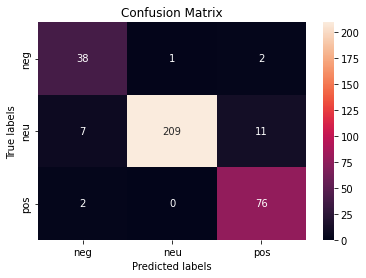

In [17]:
#Generate confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt     

matrix = confusion_matrix(labels,predictions)

ax= plt.subplot()
sns.heatmap(matrix, annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['neg', 'neu', 'pos']); ax.yaxis.set_ticklabels(['neg', 'neu', 'pos']);

/home/jingyang/anaconda3/envs/olamproject/lib/python3.9/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


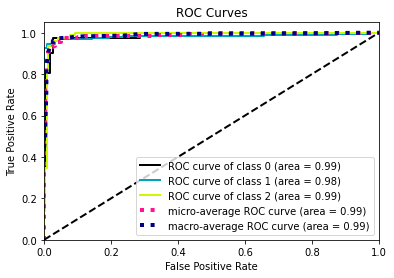

In [18]:
#Generate ROC curve
import scikitplot as skplt
import matplotlib.pyplot as plt

skplt.metrics.plot_roc_curve(labels, logits)
plt.show()